# Explore updated texture inputdata of CLM

ctsm5.2 WISE30sec percent clay and sand dataset


Inne Vanderkelen - October 2023

## 1. Settings

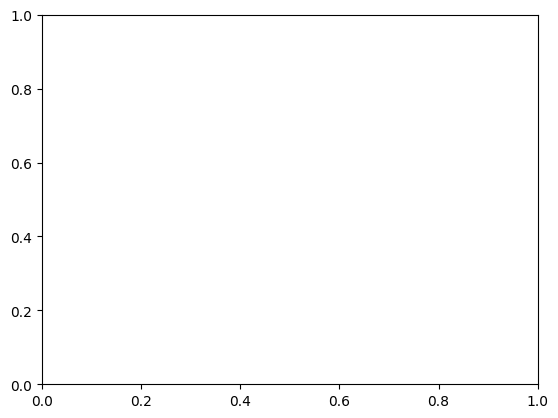

In [1]:
# laod modules 

import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

## 2. Load data

In [3]:
ds = xr.open_dataset('/scratch/snx3000/ivanderk/processing_4p1000/surfdata_4p1000/surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_CTL.nc')
da = ds.zbedrock

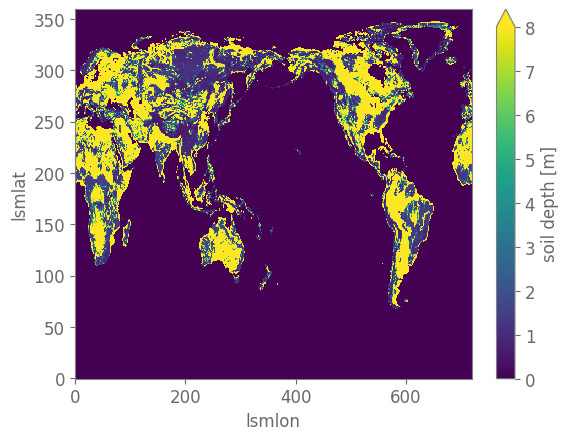

In [4]:
da.plot(vmax=8)

In [5]:
# load an instance of the control case for auxiliary purposes
ds_ctl =  load_case_ctl(['H2OSOI'])

# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY','PCT_CROP','PCT_NAT_PFT','zbedrock']


# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata('CTL', input_variables, 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2')

# get cropland and grassland mask
cropland_mask = ds_input['PCT_CROP']>0
grassland_mask = ds_input['PCT_NAT_PFT'].sel(natpft=13) + ds_input['PCT_NAT_PFT'].sel(natpft=14)


In [6]:
# define tresholds for pct sand and pct clay
pct_sand_treshold_min = 60
pct_sand_treshold_max = 85
pct_clay_threshold = 40

# sand and clay datasets 
da_pct_sand = ds_input['PCT_SAND'].assign_coords({"nlevsoi": (levsoi_thickness[:10])})
da_pct_clay = ds_input['PCT_CLAY'].assign_coords({"nlevsoi": (levsoi_thickness[:10])})

da_pct_sand_2d = da_pct_sand.weighted(da_pct_sand.nlevsoi).mean('nlevsoi')
da_pct_clay_2d = da_pct_clay.weighted(da_pct_clay.nlevsoi).mean('nlevsoi')

# weight masks over soil profile
da_sand_mask = (da_pct_sand_2d > pct_sand_treshold_min) * (da_pct_sand_2d < pct_sand_treshold_max)
da_clay_mask = da_pct_clay_2d > pct_clay_threshold

### Load auxiliary data 

## 3. Analysis & plotting

### Plotting settings

In [7]:
## settings

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

# get region names and abbreviations

region_names = {}
region_abbrevs = {}

for region_id in region_ids: 
    region_name = regionmask.defined_regions.ar6.land[region_id].name
    region_abbrev = regionmask.defined_regions.ar6.land[region_id].abbrev

    region_names [region_id]= region_name
    region_abbrevs[region_id] = region_abbrev
    
    

plotting_depth = 2 # m 8
figsize = (17,38)


### Plot soil depth

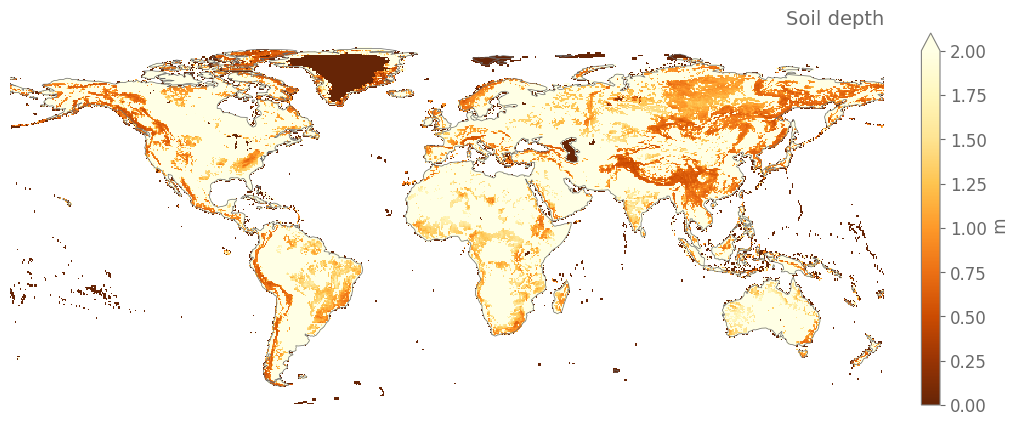

In [8]:
da_soildepth = ds_input['zbedrock'] #.assign_coords({"nlevsoi": (levsoi_thickness[:10])})
da_toplot = da_soildepth

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,110,10)
da_toplot.where(landmask).plot(ax=ax, cmap='YlOrBr_r', cbar_kwargs={'label': ' m', 'fraction': 0.02, 'pad': 0.04}, vmax=2)
ax.set_title(' ', loc='center')
ax.set_title('Soil depth', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

### Plot percent sand and percent clay maps

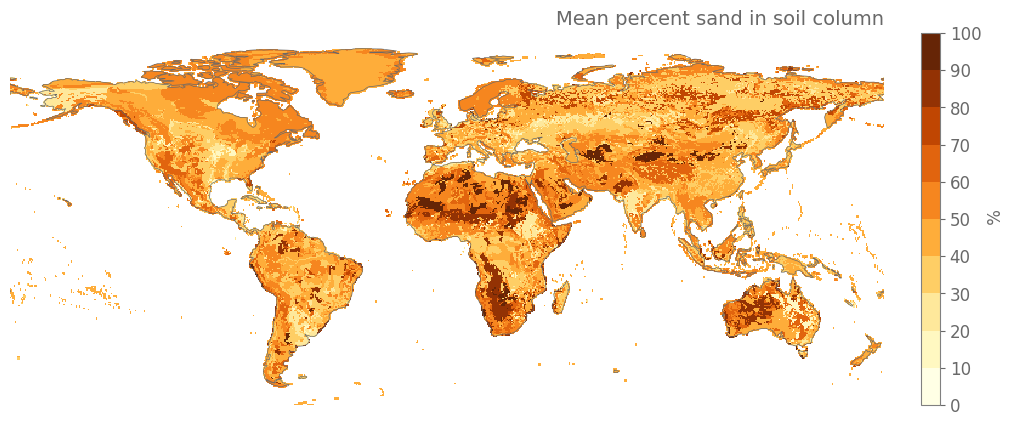

In [9]:
da_toplot = da_pct_sand_2d

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,110,10)
da_toplot.where(landmask).plot(ax=ax, cmap='YlOrBr', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean percent sand in soil column', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

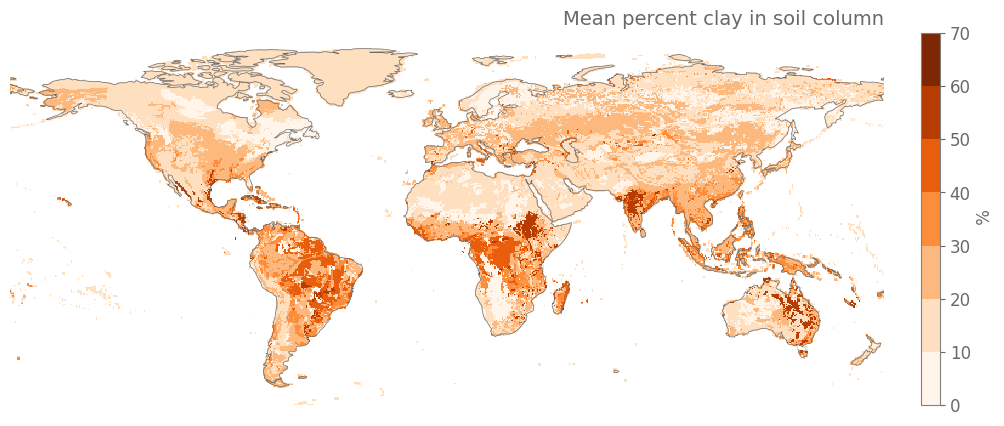

In [10]:
da_toplot = da_pct_clay_2d

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,80,10)
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean percent clay in soil column', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

### Plot masks

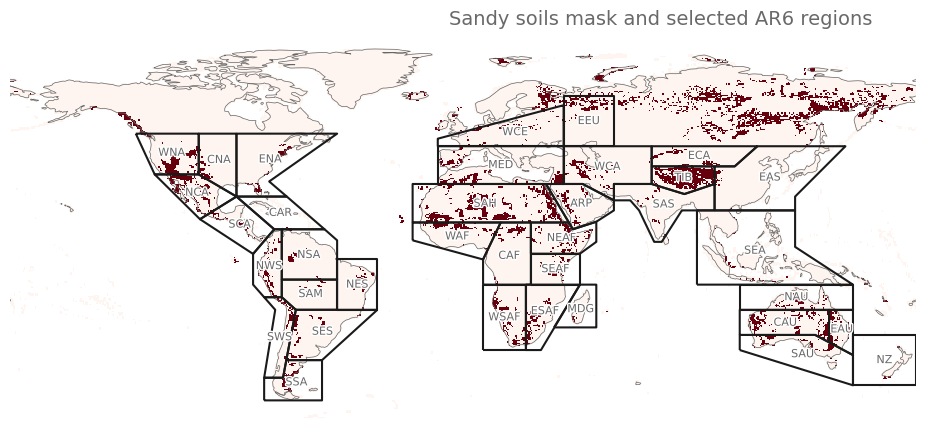

In [11]:
# plot sand mask
da_toplot = da_sand_mask

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
da_toplot.where(landmask).plot(ax=ax, cmap='Reds', add_colorbar=False);
ax.set_title(' ', loc='center');
ax.set_title('Sandy soils mask and selected AR6 regions       ', loc='right');
ax.coastlines(color='lightgray', linewidth=0.1);
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');
text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
regionmask.defined_regions.ar6.land[region_ids].plot(ax=ax, projection=ccrs.PlateCarree(),text_kws=text_kws, add_ocean=False, label="abbrev");


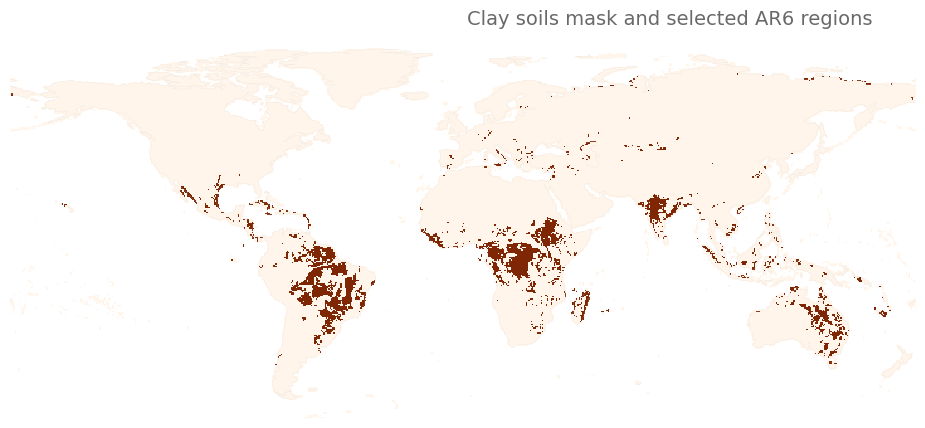

In [17]:
# plot clay mask
da_toplot = da_clay_mask

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', add_colorbar=False);
ax.set_title(' ', loc='center');
ax.set_title('Clay soils mask and selected AR6 regions       ', loc='right');
ax.coastlines(color='lightgray', linewidth=0.1);
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');
text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
#regionmask.defined_regions.ar6.land[region_ids].plot(ax=ax, projection=ccrs.PlateCarree(),text_kws=text_kws, add_ocean=False, label="abbrev");


### Plot grid cell counts per region

In [18]:
textures = ['sand','clay']

# calculate number of grid cells of SAND
da_ngridcells_sand = calc_ngridcells_ofmask_inregion(da_sand_mask, mask, region_ids)
da_ngridcells_clay = calc_ngridcells_ofmask_inregion(da_clay_mask, mask, region_ids)

d_ngridcells = {}
d_ngridcells['sand'] = da_ngridcells_sand
d_ngridcells['clay'] = da_ngridcells_clay

# save it as a pandas dataframe
df_ngridcells_region = pd.concat([pd.Series(region_names), pd.Series(region_abbrevs), d_ngridcells['sand'].to_pandas(), d_ngridcells['clay'].to_pandas()], axis=1)
df_ngridcells_region.columns = ['name','abbrev','ncells sand','ncells clay']


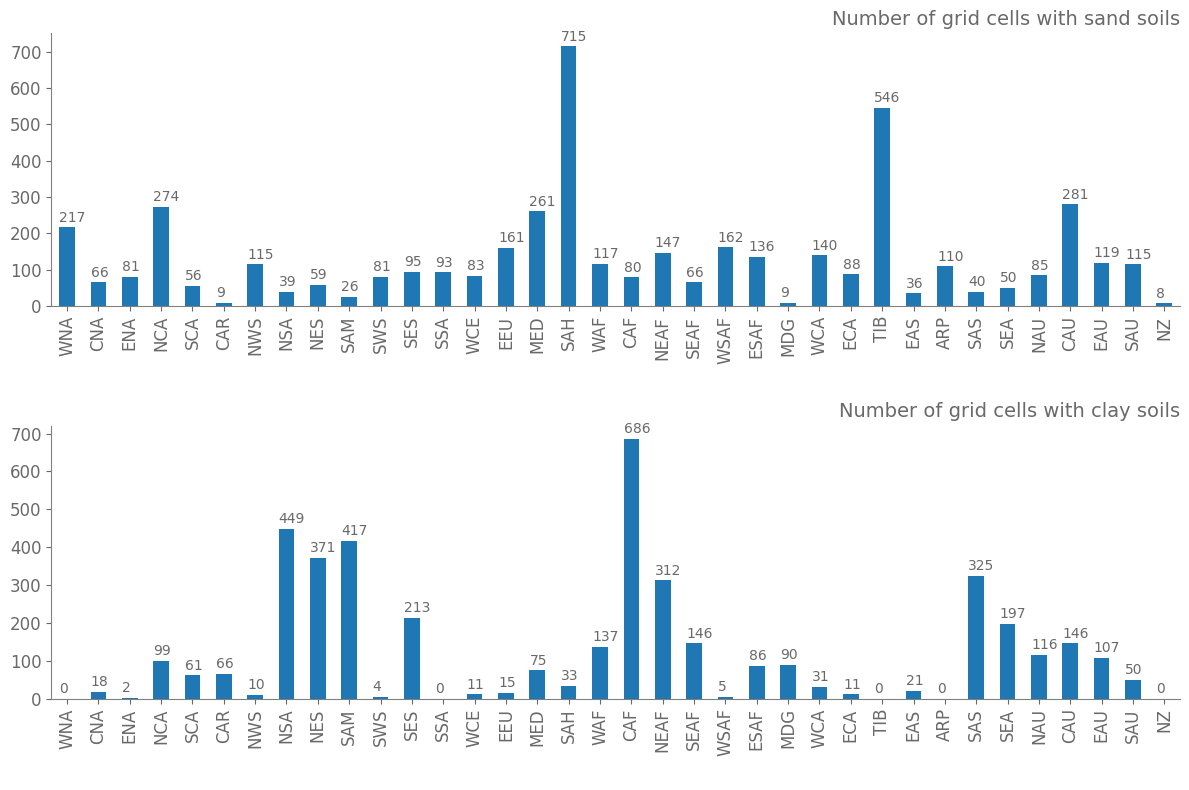

In [20]:
# plotting
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes = axes.flatten()

for n,texture in enumerate(textures): 
    
    ngridcells = d_ngridcells[texture].values
    regions_toplot = d_ngridcells[texture].region.values

    ax = axes[n]
    df_ngridcells_region[['abbrev','ncells '+texture]].plot.bar(ax=ax, x='abbrev', legend=False)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() +15))
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(' ')
    ax.set_title('Number of grid cells with '+texture+' soils',loc='right');
plt.tight_layout()

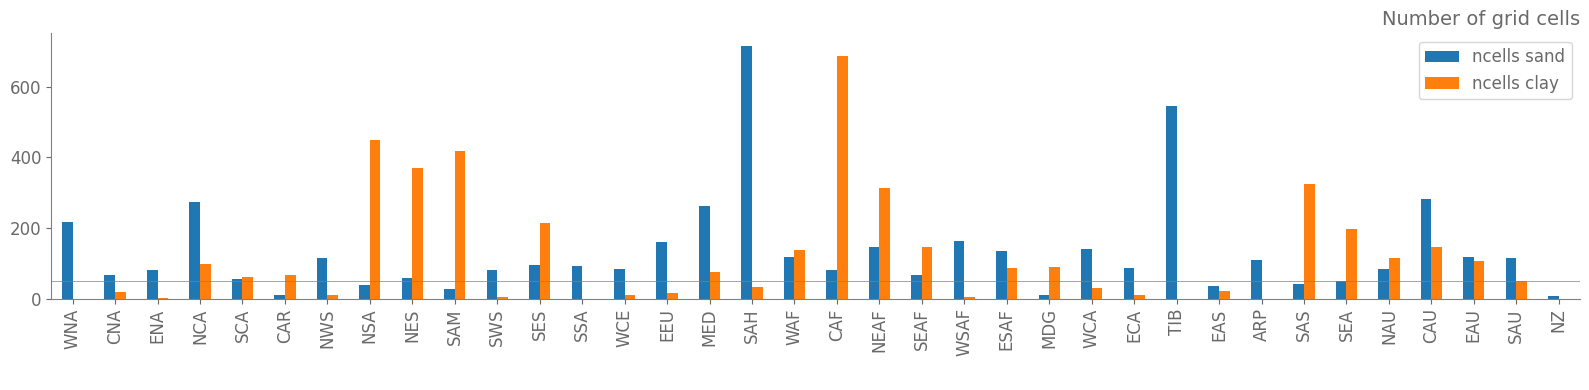

In [29]:
# plotting
fig, ax = plt.subplots(figsize=(16,4))
    
ngridcells = d_ngridcells[texture].values
regions_toplot = d_ngridcells[texture].region.values
ax.axhline(y=50, color='grey', linewidth=0.5)

df_ngridcells_region.plot.bar(ax=ax, x='abbrev')
#for p in ax.patches:
#    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() +15))
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(' ')
ax.set_title('Number of grid cells',loc='right');
plt.tight_layout()

In [39]:
df_selected_regions = df_ngridcells_region[df_ngridcells_region['ncells sand']>50][df_ngridcells_region['ncells clay']>50]
list(df_selected_regions.index)

[6, 7, 11, 14, 19, 21, 22, 23, 24, 26, 39, 40, 41]

## Similar plots BUT for CROPLAND only

In [22]:
landmask = cropland_mask

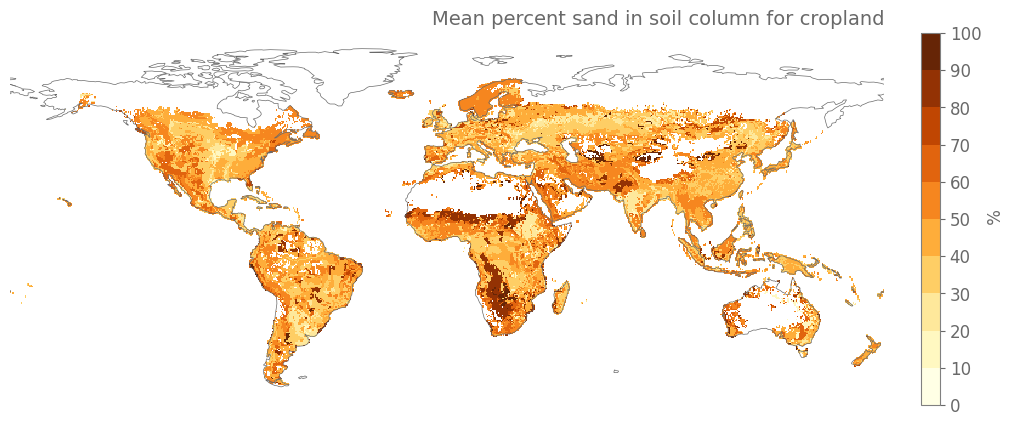

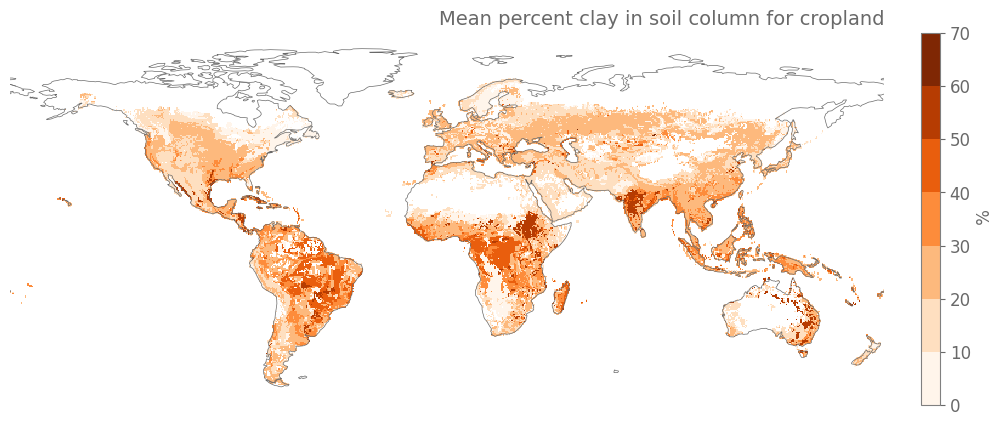

In [23]:
da_toplot = da_pct_sand_2d

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,110,10)
da_toplot.where(landmask).plot(ax=ax, cmap='YlOrBr', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean percent sand in soil column for cropland', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

da_toplot = da_pct_clay_2d

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,80,10)
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean percent clay in soil column for cropland', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

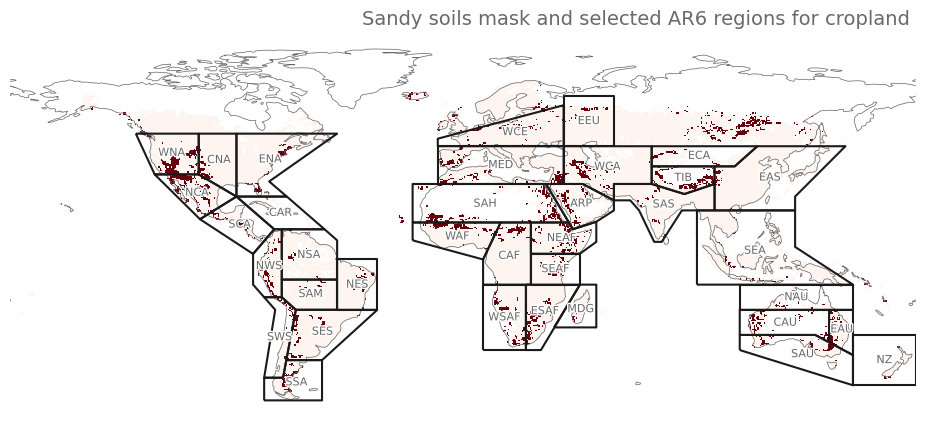

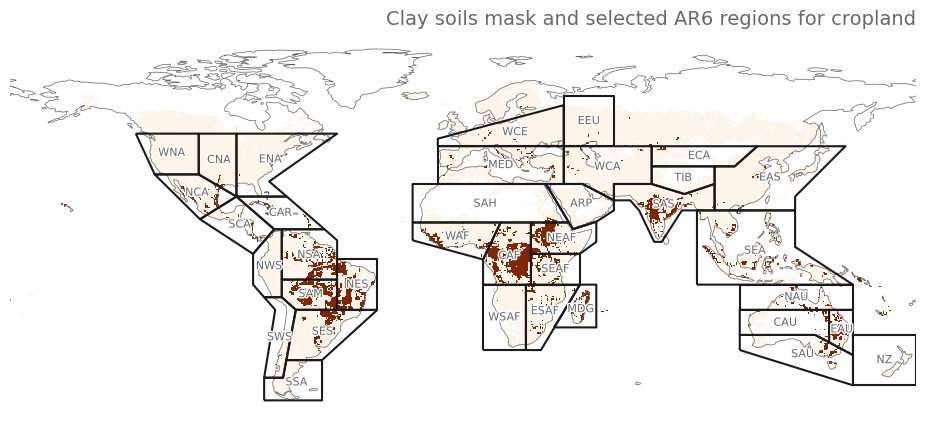

In [24]:
# plot sand mask
da_toplot = da_sand_mask

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
da_toplot.where(landmask).plot(ax=ax, cmap='Reds', add_colorbar=False);
ax.set_title(' ', loc='center');
ax.set_title('Sandy soils mask and selected AR6 regions for cropland ', loc='right');
ax.coastlines(color='lightgray', linewidth=0.1);
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');
text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
regionmask.defined_regions.ar6.land[region_ids].plot(ax=ax, projection=ccrs.PlateCarree(),text_kws=text_kws, add_ocean=False, label="abbrev");

# plot clay mask
da_toplot = da_clay_mask

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', add_colorbar=False);
ax.set_title(' ', loc='center');
ax.set_title('Clay soils mask and selected AR6 regions for cropland', loc='right');
ax.coastlines(color='lightgray', linewidth=0.1);
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');
text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
regionmask.defined_regions.ar6.land[region_ids].plot(ax=ax, projection=ccrs.PlateCarree(),text_kws=text_kws, add_ocean=False, label="abbrev");



In [43]:
textures = ['sand','clay']

# calculate number of grid cells of SAND
da_ngridcells_sand = calc_ngridcells_ofmask_inregion(da_sand_mask.where(cropland_mask), mask, region_ids)
da_ngridcells_clay = calc_ngridcells_ofmask_inregion(da_clay_mask.where(cropland_mask), mask, region_ids)

d_ngridcells = {}
d_ngridcells['sand'] = da_ngridcells_sand
d_ngridcells['clay'] = da_ngridcells_clay

# save it as a pandas dataframe
df_ngridcells_region = pd.concat([pd.Series(region_names), pd.Series(region_abbrevs), d_ngridcells['sand'].to_pandas(), d_ngridcells['clay'].to_pandas()], axis=1)
df_ngridcells_region.columns = ['name','abbrev','ncells sand','ncells clay']


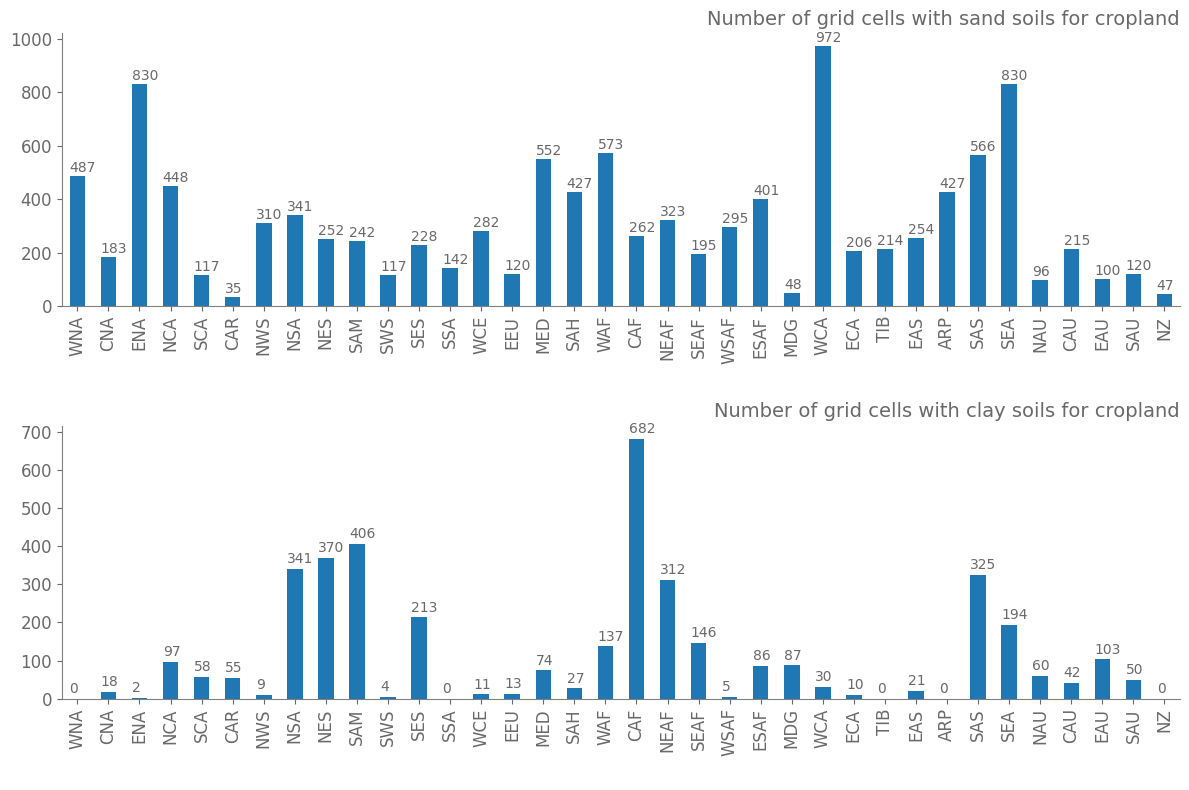

In [44]:
# plotting
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes = axes.flatten()

for n,texture in enumerate(textures): 
    
    ngridcells = d_ngridcells[texture].values
    regions_toplot = d_ngridcells[texture].region.values

    ax = axes[n]
    df_ngridcells_region[['abbrev','ncells '+texture]].plot.bar(ax=ax, x='abbrev', legend=False)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() +15))
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(' ')
    ax.set_title('Number of grid cells with '+texture+' soils for cropland',loc='right');
plt.tight_layout()

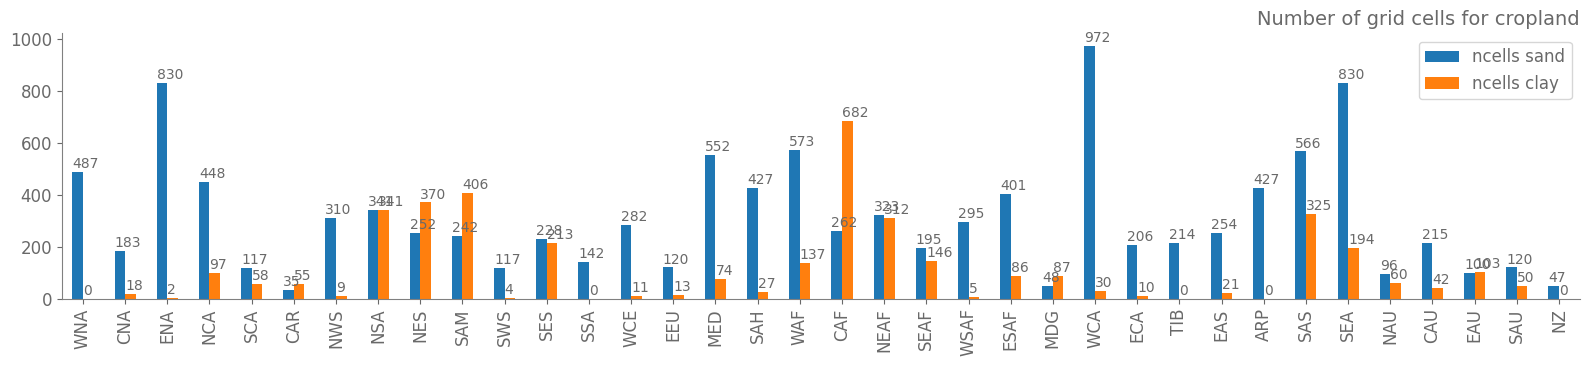

In [45]:
# plotting
fig, ax = plt.subplots(figsize=(16,4))
    
ngridcells = d_ngridcells[texture].values
regions_toplot = d_ngridcells[texture].region.values

df_ngridcells_region.plot.bar(ax=ax, x='abbrev')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() +15))
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(' ')
ax.set_title('Number of grid cells for cropland',loc='right');
plt.tight_layout()

In [53]:
len(df_ngridcells_region)

36

In [70]:
ngridcell_threshold = 50

sand_regions = list(df_ngridcells_region[df_ngridcells_region['ncells sand']>ngridcell_threshold].index)
clay_regions = list(df_ngridcells_region[df_ngridcells_region['ncells clay']>ngridcell_threshold].index)


sand_and_clay_regions = list(df_ngridcells_region[df_ngridcells_region['ncells sand']>ngridcell_threshold][df_ngridcells_region['ncells clay']>ngridcell_threshold].index)

sand_and_clay_regions

[6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

## Similar plots but for GRASSLAND only

In [43]:
landmask = grassland_mask

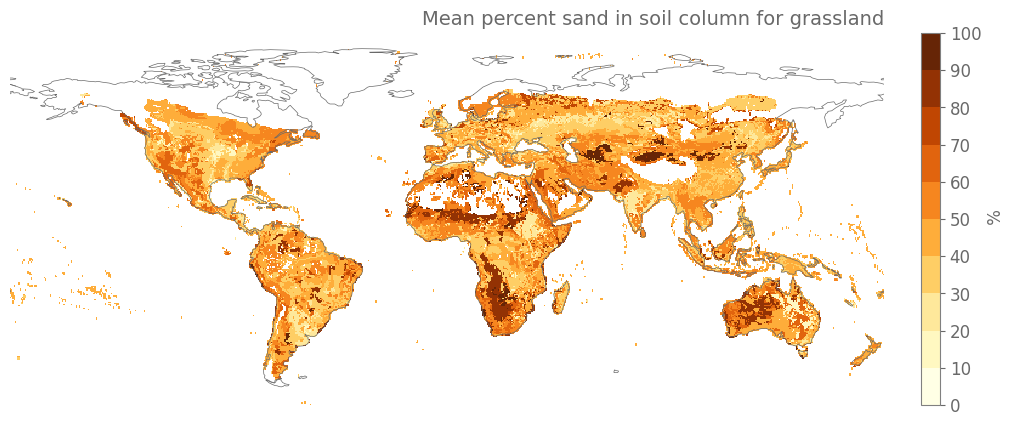

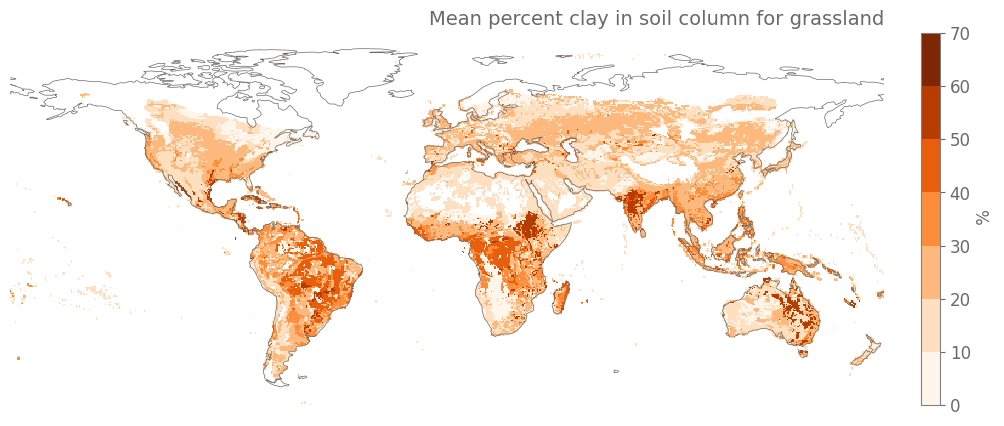

In [44]:
da_toplot = da_pct_sand_2d

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,110,10)
da_toplot.where(landmask).plot(ax=ax, cmap='YlOrBr', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean percent sand in soil column for grassland', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

da_toplot = da_pct_clay_2d

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

levels = np.arange(0,80,10)
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean percent clay in soil column for grassland', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

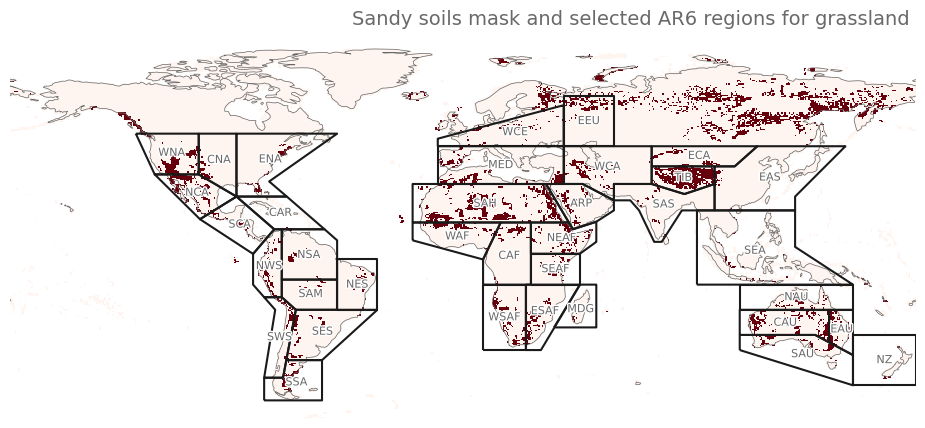

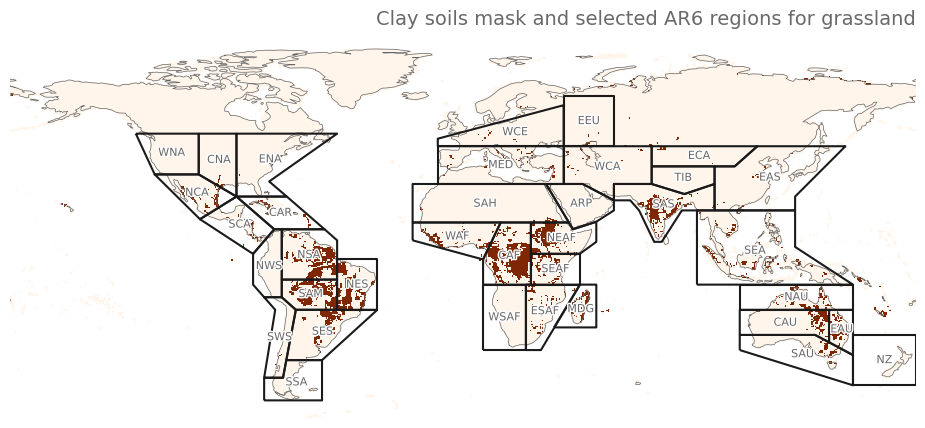

In [15]:
# plot sand mask
da_toplot = da_sand_mask

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
da_toplot.where(landmask).plot(ax=ax, cmap='Reds', add_colorbar=False);
ax.set_title(' ', loc='center');
ax.set_title('Sandy soils mask and selected AR6 regions for grassland ', loc='right');
ax.coastlines(color='lightgray', linewidth=0.1);
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');
text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
regionmask.defined_regions.ar6.land[region_ids].plot(ax=ax, projection=ccrs.PlateCarree(),text_kws=text_kws, add_ocean=False, label="abbrev");

# plot clay mask
da_toplot = da_clay_mask

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', add_colorbar=False);
ax.set_title(' ', loc='center');
ax.set_title('Clay soils mask and selected AR6 regions for grassland', loc='right');
ax.coastlines(color='lightgray', linewidth=0.1);
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');
text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
regionmask.defined_regions.ar6.land[region_ids].plot(ax=ax, projection=ccrs.PlateCarree(),text_kws=text_kws, add_ocean=False, label="abbrev");



In [46]:
textures = ['sand','clay']

# calculate number of grid cells of SAND
da_ngridcells_sand = calc_ngridcells_ofmask_inregion(da_sand_mask.where(cropland_mask), mask, region_ids)
da_ngridcells_clay = calc_ngridcells_ofmask_inregion(da_clay_mask.where(cropland_mask), mask, region_ids)

d_ngridcells = {}
d_ngridcells['sand'] = da_ngridcells_sand
d_ngridcells['clay'] = da_ngridcells_clay

# save it as a pandas dataframe
df_ngridcells_region = pd.concat([pd.Series(region_names), pd.Series(region_abbrevs), d_ngridcells['sand'].to_pandas(), d_ngridcells['clay'].to_pandas()], axis=1)
df_ngridcells_region.columns = ['name','abbrev','ncells sand','ncells clay']


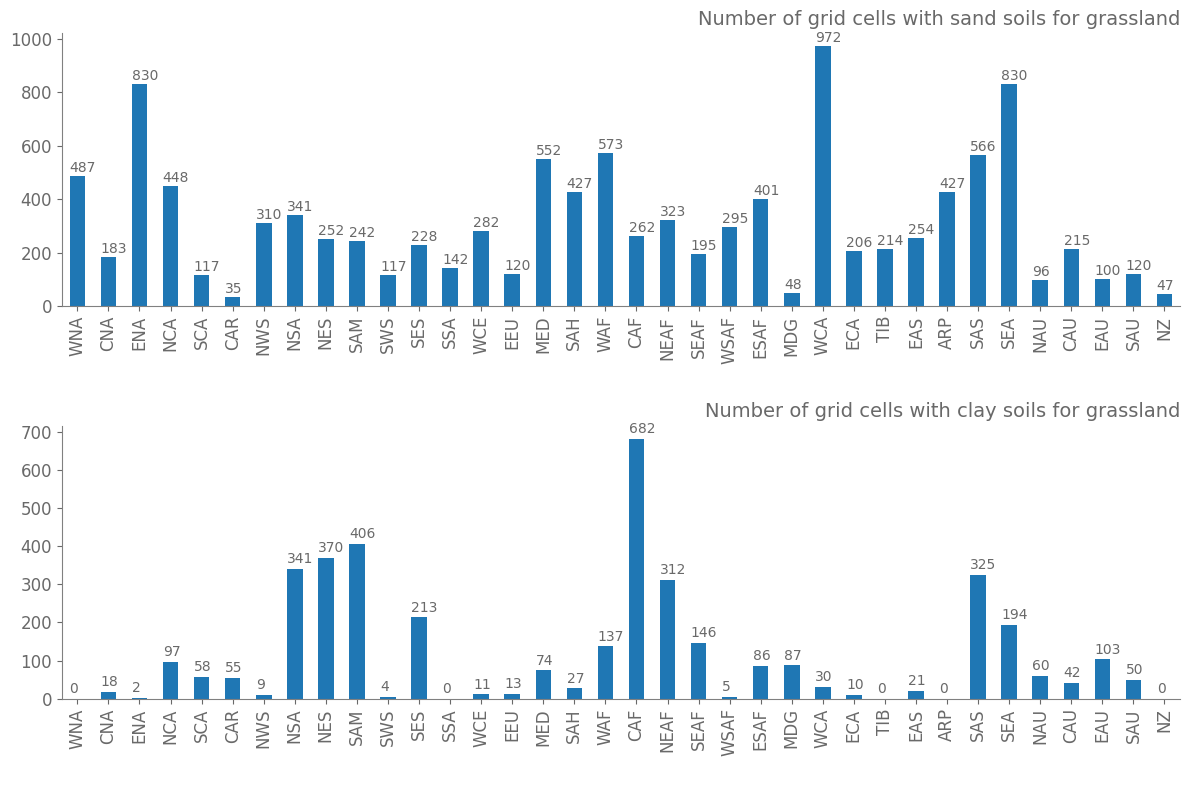

In [47]:
# plotting
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes = axes.flatten()

for n,texture in enumerate(textures): 
    
    ngridcells = d_ngridcells[texture].values
    regions_toplot = d_ngridcells[texture].region.values

    ax = axes[n]
    df_ngridcells_region[['abbrev','ncells '+texture]].plot.bar(ax=ax, x='abbrev', legend=False)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() +15))
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(' ')
    ax.set_title('Number of grid cells with '+texture+' soils for grassland',loc='right');
plt.tight_layout()

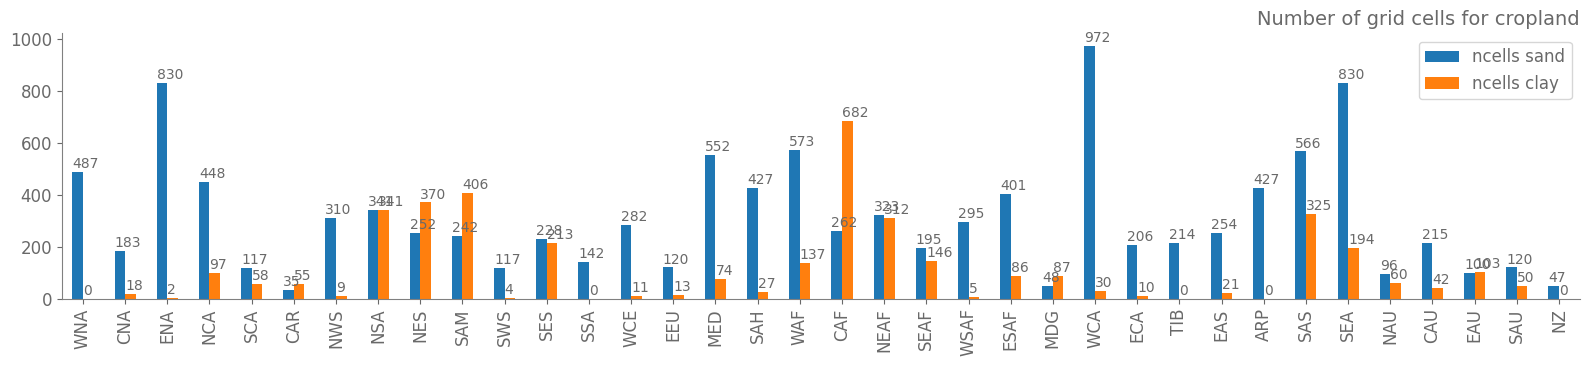

In [48]:
# plotting
fig, ax = plt.subplots(figsize=(16,4))
    
ngridcells = d_ngridcells[texture].values
regions_toplot = d_ngridcells[texture].region.values

df_ngridcells_region.plot.bar(ax=ax, x='abbrev')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() +15))
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(' ')
ax.set_title('Number of grid cells for cropland',loc='right');
plt.tight_layout()